# import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pprint import pprint
import time
import sys
import platform

In [2]:
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute
from qiskit.tools.visualization import plot_histogram
from qiskit.providers.aer import noise
from qiskit.ignis.mitigation.measurement import tensored_meas_cal, TensoredMeasFitter

# Environment

In [3]:
# device version
pprint(platform.machine())
pprint(platform.version())
pprint(platform.platform())
pprint(platform.uname())
pprint(platform.system())
pprint(platform.processor())

'x86_64'
('Darwin Kernel Version 19.5.0: Tue May 26 20:41:44 PDT 2020; '
 'root:xnu-6153.121.2~2/RELEASE_X86_64')
'Darwin-19.5.0-x86_64-i386-64bit'
uname_result(system='Darwin', node='Yang-no-MBP', release='19.5.0', version='Darwin Kernel Version 19.5.0: Tue May 26 20:41:44 PDT 2020; root:xnu-6153.121.2~2/RELEASE_X86_64', machine='x86_64', processor='i386')
'Darwin'
'i386'


In [4]:
# python version
pprint(sys.version)

('3.7.7 (default, May  6 2020, 04:59:01) \n'
 '[Clang 4.0.1 (tags/RELEASE_401/final)]')


In [5]:
# qiskit version
qiskit.__qiskit_version__

{'qiskit-terra': '0.16.1',
 'qiskit-aer': '0.7.1',
 'qiskit-ignis': '0.5.1',
 'qiskit-ibmq-provider': '0.11.1',
 'qiskit-aqua': '0.8.1',
 'qiskit': '0.23.1'}

# Measure the time of tensored calibration for GHZ state from size 2 to 12
- Testing for "pseudo_inverse" method
- Using the original TensoredFilter.apply() function

In [6]:
lim = 13
times = []
noisy_counts_of_each_size = []
mitigated_counts_of_each_size = []

In [7]:
for n in range(2,lim):
    # n = 14
    print("experiment of ", n, "-qubit GHZ state")

    # create n qubit tensored measurement calibration circuits
    qr = qiskit.QuantumRegister(n)
    mit_pattern = [[i] for i in range(n)]
    meas_calibs, state_labels = tensored_meas_cal(mit_pattern=mit_pattern, qr=qr, circlabel='mcal')
    print("mit pattern: ", mit_pattern)
    print("number of calibration circuits: ", len(meas_calibs), "-> the circuits for '000...0' and '111...1'")

    # prepare noise model of n qubits
    noise_model = noise.NoiseModel()
    for qi in range(n):
        if qi <= 2:
            continue
        read_err = noise.errors.readout_error.ReadoutError([[0.9, 0.1],[0.25,0.75]])
        noise_model.add_readout_error(read_err, [qi])

    # execute the calibration circuits
    job = qiskit.execute(meas_calibs, backend=Aer.get_backend('qasm_simulator'), shots=5000, noise_model=noise_model)
    cal_results = job.result()
    meas_fitter = TensoredMeasFitter(cal_results, mit_pattern=mit_pattern)
    print(meas_fitter.cal_matrices)

    # create n-qubit GHZ state
    m = n
    cr = ClassicalRegister(m)
    ghz = QuantumCircuit(qr, cr)
    ghz.h(qr[0])
    for i in range(1,m):
        ghz.cx(qr[0], qr[i])
    ghz.barrier()
    for i in range(m):
        ghz.measure(qr[i],cr[i])
    # ghz.draw("mpl")

    # execute GHZ circuit
    job = qiskit.execute([ghz], backend=Aer.get_backend("qasm_simulator"), shots=5000, noise_model=noise_model)
    noisy_counts = job.result().get_counts()

    # Get the filter object
    meas_filter = meas_fitter.filter

    t1 = time.time()
    # Results with mitigation
    mitigated_counts = meas_filter.apply(noisy_counts, "pseudo_inverse")
    t2 = time.time()

    print("time of mitigation for", n, "qubits GHZ state: ", t2 - t1, "[s]")
    times.append(t2 - t1)

    noisy_counts_of_each_size.append(noisy_counts)
    mitigated_counts_of_each_size.append(mitigated_counts)
    
    print()

experiment of  2 -qubit GHZ state
mit pattern:  [[0], [1]]
number of calibration circuits:  2 -> the circuits for '000...0' and '111...1'
[array([[1., 0.],
       [0., 1.]]), array([[1., 0.],
       [0., 1.]])]
time of mitigation for 2 qubits GHZ state:  0.0004930496215820312 [s]

experiment of  3 -qubit GHZ state
mit pattern:  [[0], [1], [2]]
number of calibration circuits:  2 -> the circuits for '000...0' and '111...1'
[array([[1., 0.],
       [0., 1.]]), array([[1., 0.],
       [0., 1.]]), array([[1., 0.],
       [0., 1.]])]
time of mitigation for 3 qubits GHZ state:  0.0005271434783935547 [s]

experiment of  4 -qubit GHZ state
mit pattern:  [[0], [1], [2], [3]]
number of calibration circuits:  2 -> the circuits for '000...0' and '111...1'
[array([[1., 0.],
       [0., 1.]]), array([[1., 0.],
       [0., 1.]]), array([[1., 0.],
       [0., 1.]]), array([[0.8982, 0.2482],
       [0.1018, 0.7518]])]
time of mitigation for 4 qubits GHZ state:  0.0008471012115478516 [s]

experiment of  

In [8]:
pprint(times)

[0.0004930496215820312,
 0.0005271434783935547,
 0.0008471012115478516,
 0.001912832260131836,
 0.006255149841308594,
 0.022062063217163086,
 0.08552694320678711,
 0.3194749355316162,
 1.2126538753509521,
 4.340131998062134,
 16.067579984664917]


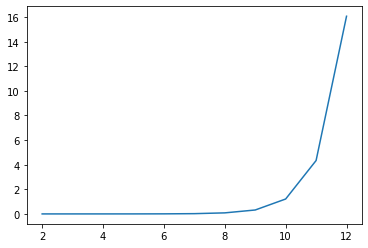

In [9]:
plt.plot(range(2, lim), times)

# Check whether the mitigation is done successfully

In [10]:
for i in range(lim - 2):
    print("noisy counts of", i + 2, "qubit GHZ state")
    pprint(noisy_counts_of_each_size[i])
    print("mitigated counts of", i + 2, "qubit GHZ state")
    pprint(mitigated_counts_of_each_size[i])
    print()

noisy counts of 2 qubit GHZ state
{'00': 2508, '11': 2492}
mitigated counts of 2 qubit GHZ state
{'00': 2508.0, '11': 2492.0}

noisy counts of 3 qubit GHZ state
{'000': 2541, '111': 2459}
mitigated counts of 3 qubit GHZ state
{'000': 2541.0, '111': 2459.0}

noisy counts of 4 qubit GHZ state
{'0000': 2198, '0111': 636, '1000': 231, '1111': 1935}
mitigated counts of 4 qubit GHZ state
{'0000': 2454.034153846153,
 '0111': -3.2649230769230826,
 '1000': -25.034153846153743,
 '1111': 2574.264923076924}

noisy counts of 5 qubit GHZ state
{'00000': 2063,
 '00111': 157,
 '01000': 217,
 '01111': 498,
 '10000': 220,
 '10111': 470,
 '11000': 30,
 '11111': 1345}
mitigated counts of 5 qubit GHZ state
{'00000': 2552.6655888117466,
 '00111': -22.017712666800435,
 '01000': -34.31901179463298,
 '01111': 80.07700362034575,
 '10000': -1.5368574684645608,
 '10111': 22.19495147277064,
 '11000': 13.190280451349594,
 '11111': 2389.745757573682}

noisy counts of 6 qubit GHZ state
{'000000': 1846,
 '000111': 32,

{'000000000': 2634.3942933380376,
 '000000111': 2.87295072455254,
 '000001000': -26.321925813434426,
 '000001111': -3.8289405985821743,
 '000010000': 0.8261588040771257,
 '000010111': -0.6374837313256156,
 '000011000': 6.6106785173275115,
 '000011111': -16.60372829208127,
 '000100000': 7.736728472606925,
 '000100111': 1.007671181129826,
 '000101000': -11.2197701706966,
 '000101111': 2.949904800088399,
 '000110000': -11.604916673120039,
 '000110111': -5.431165013071762,
 '000111000': -2.010824354497232,
 '000111111': 30.94200547647401,
 '001000000': -37.04278418837403,
 '001000111': -5.3313231227712174,
 '001001000': 8.343398580416787,
 '001001111': -12.202707541324664,
 '001010000': 6.427898352845762,
 '001010111': -2.073166109105511,
 '001011000': -2.077869367697813,
 '001011111': 40.30114616896479,
 '001100000': -9.41910620095222,
 '001100111': -6.011585926878915,
 '001101000': 5.551343293787559,
 '001101111': 28.10672947332195,
 '001110000': 3.0032023687939837,
 '001110111': 5.29242

 '1110101111': -55.131624465068285,
 '1110110000': -0.220215574903655,
 '1110110111': -97.79072202207584,
 '1110111000': -0.03234156666110364,
 '1110111111': 153.5881585594028,
 '1111000000': -3.5538108607253305,
 '1111000111': -7.754166138440283,
 '1111001000': 7.490149046771676,
 '1111001111': -61.64660555776865,
 '1111010000': 0.8686779473265915,
 '1111010111': -20.132284586020376,
 '1111011000': -1.0088440070723574,
 '1111011111': 55.46756454189574,
 '1111100000': -2.8943711572710464,
 '1111100111': 0.44939668562008706,
 '1111101000': -0.52745481926248,
 '1111101111': 85.68577109929902,
 '1111110000': 0.2639402412329582,
 '1111110111': 63.72502074141482,
 '1111111000': 0.08476349412525035,
 '1111111111': 2292.0019832010303}

noisy counts of 11 qubit GHZ state
{'00000000000': 1095,
 '00000001000': 125,
 '00000010000': 97,
 '00000011000': 10,
 '00000100000': 99,
 '00000101000': 15,
 '00000110000': 15,
 '00000111000': 2,
 '00000111111': 1,
 '00001000000': 112,
 '00001001000': 17,
 '00

 '10001101000': 0.05776295641537844,
 '10001101111': 2.4245613784573212,
 '10001110000': -2.153777513344549,
 '10001110111': 8.857880794578731,
 '10001111000': 0.9559827743500681,
 '10001111111': -11.753381251252101,
 '10010000000': 25.109781682478896,
 '10010000111': 5.579378025534041,
 '10010001000': -9.420677935792297,
 '10010001111': -3.906343484260919,
 '10010010000': -15.116584435112625,
 '10010010111': 2.3155761047033696,
 '10010011000': 7.412492400955719,
 '10010011111': -29.668894835369017,
 '10010100000': -12.940913331499635,
 '10010100111': 3.194401270366103,
 '10010101000': 7.422875952816851,
 '10010101111': -2.9874650371548697,
 '10010110000': 0.46188104548180714,
 '10010110111': -14.155819008660266,
 '10010111000': -1.2236826505624232,
 '10010111111': 57.438818001419875,
 '10011000000': -18.6857546168562,
 '10011000111': -5.839814593137586,
 '10011001000': 3.473032777410878,
 '10011001111': 6.501014679770982,
 '10011010000': 2.5303391762908523,
 '10011010111': -8.40776880

 '000010011000': 1,
 '000010011111': 2,
 '000010100000': 12,
 '000010101000': 1,
 '000010110000': 2,
 '000010110111': 1,
 '000011000000': 11,
 '000011001000': 1,
 '000011010111': 1,
 '000011011111': 2,
 '000011100000': 1,
 '000011100111': 1,
 '000011111111': 2,
 '000100000000': 118,
 '000100001000': 11,
 '000100010000': 21,
 '000100011000': 1,
 '000100100000': 12,
 '000100101000': 1,
 '000100110000': 2,
 '000100111111': 1,
 '000101000000': 10,
 '000101001000': 1,
 '000101001111': 1,
 '000101010000': 2,
 '000101011111': 1,
 '000101100000': 2,
 '000101100111': 1,
 '000101101111': 1,
 '000101111111': 1,
 '000110000000': 12,
 '000110001000': 1,
 '000110011111': 1,
 '000110100000': 1,
 '000110100111': 1,
 '000110101000': 1,
 '000110101111': 1,
 '000110111111': 2,
 '000111001000': 1,
 '000111011111': 4,
 '000111101111': 2,
 '000111110111': 4,
 '000111111111': 10,
 '001000000000': 117,
 '001000001000': 10,
 '001000010000': 13,
 '001000011000': 2,
 '001000011111': 1,
 '001000100000': 7,
 '0010

 '000010001111': -7.050790692758268,
 '000010010000': 17.958251376762973,
 '000010010111': -11.94102315156073,
 '000010011000': -3.653981906679881,
 '000010011111': 13.088602222570424,
 '000010100000': 13.97968846306643,
 '000010100111': -4.79747628430357,
 '000010101000': -6.498108607371621,
 '000010101111': -0.5889601057285727,
 '000010110000': 5.134237833976686,
 '000010110111': 10.066620975238799,
 '000010111000': 0.2727127961842034,
 '000010111111': 0.7408283369399271,
 '000011000000': 1.7781003412865526,
 '000011000111': -8.186724126577444,
 '000011001000': -3.435359943882656,
 '000011001111': 7.2997914123931915,
 '000011010000': -5.650413380624294,
 '000011010111': 14.913636670951812,
 '000011011000': 2.1787486048360036,
 '000011011111': -9.18040310009164,
 '000011100000': -2.457748691605413,
 '000011100111': 6.152768536656655,
 '000011101000': 1.6194129373290065,
 '000011101111': 6.196495861870042,
 '000011110000': 0.5097166175206871,
 '000011110111': -13.994439436483715,
 '000

 '010001110111': -15.661761319606956,
 '010001111000': -0.10620366551023572,
 '010001111111': 10.674551774221566,
 '010010000000': -2.4315345865800415,
 '010010000111': -4.1463108831379065,
 '010010001000': -4.4202754685705585,
 '010010001111': 8.332209751686289,
 '010010010000': -2.4893641903454125,
 '010010010111': -0.8281856628291315,
 '010010011000': 0.728261046446794,
 '010010011111': 7.336729637952985,
 '010010100000': 9.183354797794149,
 '010010100111': -6.605647173581184,
 '010010101000': -0.2302583386315451,
 '010010101111': 6.943536141233408,
 '010010110000': -2.35653100953047,
 '010010110111': 25.602797418837547,
 '010010111000': 0.22860223054011922,
 '010010111111': -45.848467733373624,
 '010011000000': -4.038787986941564,
 '010011000111': 8.819334717047935,
 '010011001000': 0.7228552285877189,
 '010011001111': -10.924084115032159,
 '010011010000': 1.0367321792346347,
 '010011010111': -7.3840422695364305,
 '010011011000': -0.1996709832154272,
 '010011011111': -8.49631976341

 '110001000111': 26.16587049750393,
 '110001001000': 13.866249202297661,
 '110001001111': -36.24637436803774,
 '110001010000': 5.875658282764817,
 '110001010111': -9.511945412692908,
 '110001011000': -3.855248971054046,
 '110001011111': -0.7919169395164083,
 '110001100000': -1.7944177959398684,
 '110001100111': -18.173142854297055,
 '110001101000': -1.6490832432298665,
 '110001101111': 32.15513326656739,
 '110001110000': -1.19634562458367,
 '110001110111': 5.98526379826367,
 '110001111000': 0.5827783191805183,
 '110001111111': 57.093801509693776,
 '110010000000': -1.5914259292867576,
 '110010000111': 7.04742099845989,
 '110010001000': 4.649905435301882,
 '110010001111': -33.6968310019236,
 '110010010000': 5.331676333970141,
 '110010010111': -7.1353895464758175,
 '110010011000': -2.366961703050202,
 '110010011111': 12.637744459329094,
 '110010100000': -3.220467162482988,
 '110010100111': 26.290613657139726,
 '110010101000': -0.19345474410540675,
 '110010101111': -9.609623889879522,
 '11